# IEEE-CIS Fraud Detection

## Summay
This is a kaggle competition which want to build a fraud detection from online transaction data.
It is a classic binary classification problem which predict the record is fraud or not.
We can see more detail [here](https://www.kaggle.com/c/ieee-fraud-detection/overview) and we will face the following topic:

- Imbalance data
- Missing value
- Modeling

## Notation

### Transaction Table 
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

### Identity Table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.


They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

## Check the Data

### Overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from matplotlib_venn import venn2
import numpy as np
import lightgbm as lgb
import gc
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
plt.style.use('ggplot')

In [2]:
train_identity = pd.read_csv("../data/train_identity.csv")
train_transaction = pd.read_csv("../data/train_transaction.csv")
test_identity = pd.read_csv("../data/test_identity.csv")
test_transaction = pd.read_csv("../data/test_transaction.csv")
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del train_identity, train_transaction, test_identity, test_transaction
gc.collect()

42

In [3]:
print("Training data shape", train.shape)
print("Training data columns name", list(train.columns))
train.head()

Training data shape (590540, 434)
Training data columns name ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [4]:
print("Testing data shape", test.shape)
print("Testing data columns name", list(test.columns))
train.head()

Testing data shape (506691, 433)
Testing data columns name ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V7

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Imbalance
Imbalance label might cost our loss function and metrics working properly.
There are something we can to:

- 1. Oversampling
- 2. Downsampling
- 3. Some trick on the loss function 

In this demo we choose **3. Some trick on the loss function** which is we gonna put the scale_pos_weight on the loss function. It will help our model "care" the postive label more.

In [5]:
print("isFraud ratio is {}".format(sum(train["isFraud"])/len(train)))

isFraud ratio is 0.03499000914417313


In [6]:
scale_pos_weight = (len(train) - sum(train["isFraud"]))/sum(train["isFraud"])
print(scale_pos_weight)

27.579586700866283


### Missing value 
- Drop the Missing Value
    - Drop the row
    - Drop the column
- Fill the Missing Value
    - Fill missing Value with average
    - Use KNN, EM or some algorithm

In this demo we choose **drop the columns** with missing value in training data. Although there are still some amount of data have missing value, but is acceptable. We also check the categorical data do not has huge different between training and testing. Finally we choose the feature as follow for modeling. 
- TransactionAmt
- ProductCD
- card1 
- C1-C14

> Note: Usually, we transform the time information into bucket like weekday_hour_0, weekend_hour_1, ... ,weekend_hour_0, weekend_hour_1, ... , but this dataset use the timedelta from a given reference datetime. It will cost huge effort to do the feature engineering therefore we drop the TransactionDT to make the data simpler.

In [7]:
# Get training missing value
train_missing_value_ratio_list = []
for key in train.columns:
    try:
        
        missing_value_ratio = sum(np.isnan(train[key]))/len(train)
        train_missing_value_ratio_list.append(missing_value_ratio)
    except Exception as e:
        missing_value_ratio = sum(list(train[key] == "null") and list(pd.isna(train[key])))/len(train)
        train_missing_value_ratio_list.append(missing_value_ratio)

In [8]:
# Get testing missing value
test_missing_value_ratio_list = []
for key in test.columns:
    try:
        missing_value_ratio = sum(np.isnan(test[key]))/len(test)
        test_missing_value_ratio_list.append(missing_value_ratio)
    except Exception as e:
        missing_value_ratio = sum(list(test[key] == "null") and list(pd.isna(test[key])))/len(test)
        test_missing_value_ratio_list.append(missing_value_ratio)

In [9]:
# Get features list without missing value
features_without_missing_value_in_train = list(train.columns[train_missing_value_ratio_list==np.float64(0)])
features_without_missing_value_in_test = list(test.columns[test_missing_value_ratio_list==np.float64(0)])

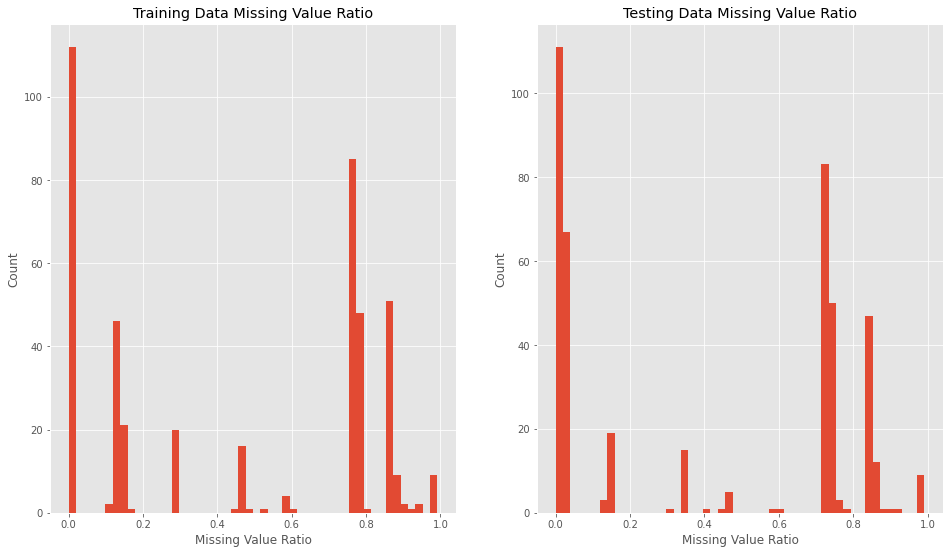

In [10]:
# Plot the histogram of missing value
plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
plt.title("Training Data Missing Value Ratio")
plt.xlabel("Missing Value Ratio")
plt.ylabel("Count")
plt.hist(train_missing_value_ratio_list, bins=50)
plt.subplot(1,2,2)
plt.title("Testing Data Missing Value Ratio")
plt.xlabel("Missing Value Ratio")
plt.ylabel("Count")
plt.hist(test_missing_value_ratio_list, bins=50)
plt.show()

In [11]:
# How many feature without the missing value
print("There are {} out of {} features without missing value in training data".format(len(features_without_missing_value_in_train), len(train.columns)))
print("There are {} out of {} features without missing value in testing data".format(len(features_without_missing_value_in_test), len(test.columns)))

There are 20 out of 434 features without missing value in training data
There are 48 out of 433 features without missing value in testing data


In [12]:
# Show the feature with out missing value
print("The feature with out missing value in training are: ")
print(features_without_missing_value_in_train)
print("\nThe feature with out missing value in testing are: ")
print(features_without_missing_value_in_test)

The feature with out missing value in training are: 
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

The feature with out missing value in testing are: 
['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137']


In [13]:
# Cross check the training feature and testing feature 
for feature in features_without_missing_value_in_train:
    if feature != "isFraud":
        try:
            missing_value_ratio = sum(np.isnan(test[feature]))/len(test)

        except Exception as e:
            missing_value_ratio = sum(list(test[feature] == "null") and list(pd.isna(test[feature])))/len(test)
        finally:
            print("Feature {} has {} ratio of missing value in testing data".format(feature, missing_value_ratio))

Feature TransactionID has 0.0 ratio of missing value in testing data
Feature TransactionDT has 0.0 ratio of missing value in testing data
Feature TransactionAmt has 0.0 ratio of missing value in testing data
Feature ProductCD has 0.0 ratio of missing value in testing data
Feature card1 has 0.0 ratio of missing value in testing data
Feature C1 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C2 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C3 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C4 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C5 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C6 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C7 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C8 has 5.920768278891869e-06 ratio of missing value in testing data
Feature C9 has 5.920768278891869e-06 ratio of missing valu

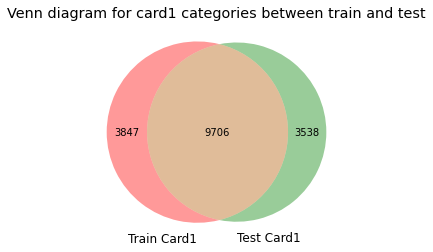

In [14]:
# Check the categorical feature between train and test
plt.title("Venn diagram for card1 categories between train and test")
venn2([set(train["card1"]), set(test["card1"])], set_labels=('Train Card1', 'Test Card1'))
plt.show()

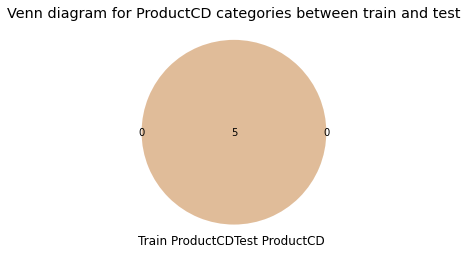

In [15]:
# Check the categorical feature between train and test
plt.title("Venn diagram for ProductCD categories between train and test")
venn2([set(train["ProductCD"]), set(test["ProductCD"])], set_labels=('Train ProductCD', 'Test ProductCD'))
plt.show()

## Modeling
We use the lightgbm to do the gradient boosting tree for our modeling part. Because above reason we choose the following feature for our modeling
- TransactionAmt
- ProductCD
- card1 
- C1-C14

where card1 and ProductCD are categorical feature.

> Note: Using the AUC metric for the imbalance data is very weird so that we put the average precision into the metrics. Average precision should be a better metric for model foucus more on differentiate the postive label which is our case.

### Feature engineering

In [16]:
#### Choose feature
all_train_x = train[
        [
            'TransactionAmt', 
            'ProductCD',
            'card1', 
            'C1', 
            'C2', 
            'C3', 
            'C4', 
            'C5', 
            'C6', 
            'C7', 
            'C8', 
            'C9', 
            'C10', 
            'C11', 
            'C12', 
            'C13', 
            'C14']]
all_train_y = train['isFraud']
all_test_x = test[
     [
            'TransactionAmt', 
            'ProductCD',
            'card1', 
            'C1', 
            'C2', 
            'C3', 
            'C4', 
            'C5', 
            'C6', 
            'C7', 
            'C8', 
            'C9', 
            'C10', 
            'C11', 
            'C12', 
            'C13', 
            'C14']]
del train, test
gc.collect()

15290

In [17]:
# Encode string feature
productCD_categories = list(np.unique(all_train_x['ProductCD']))
print("Feature ProductCD has {}".format(productCD_categories))
all_train_x["ProductCD"] = list(
            map(lambda x: productCD_categories.index(x),  all_train_x["ProductCD"]))
all_test_x["ProductCD"] = list(
            map(lambda x: productCD_categories.index(x),  all_test_x["ProductCD"]))

Feature ProductCD has ['C', 'H', 'R', 'S', 'W']


In [18]:
# Train test split
train_x, test_x, train_y, test_y = train_test_split(
    all_train_x, all_train_y, test_size=0.3, random_state=42)

In [19]:
# Put data in light gbm dataset
lgb_train = lgb.Dataset(
    train_x, 
    label=train_y,
    categorical_feature=["card1", "ProductCD"],
    free_raw_data=False
)
lgb_test = lgb.Dataset(
    test_x, 
    label=test_y,
    categorical_feature=["card1", "ProductCD"],
    free_raw_data=False,
    reference=lgb_train
)

In [20]:
# Define average_precision callback
def eval_average_precision(y_pred, train_data):
    """
    Fast auc eval function for lgb.
    """
    y_true = train_data.get_label()
    average_precision = average_precision_score(y_true, y_pred)
    return 'average precision', average_precision, True

### Fitting
Lightgbm has a lot of hyperparams and tuning those hyperparams is a huge topic. We use the default params in this demo.

In [21]:
params = {}
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = ['binary_logloss', 'auc']  
params['verbose'] = 1
params['scale_pos_weight'] = scale_pos_weight

In [22]:
bst = lgb.train(
    params, 
    lgb_train, 
    valid_sets=lgb_test, 
    feval=eval_average_precision)

/home/wu/.local/share/virtualenvs/lightgbm-project-demo-blx0_w_h/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's binary_logloss: 0.150402	valid_0's auc: 0.860566	valid_0's average precision: 0.244804
[2]	valid_0's binary_logloss: 0.162477	valid_0's auc: 0.876924	valid_0's average precision: 0.297653
[3]	valid_0's binary_logloss: 0.174524	valid_0's auc: 0.884873	valid_0's average precision: 0.330622
[4]	valid_0's binary_logloss: 0.186519	valid_0's auc: 0.889787	valid_0's average precision: 0.344886
[5]	valid_0's binary_logloss: 0.19865	valid_0's auc: 0.892906	valid_0's average precision: 0.352821
[6]	valid_0's binary_logloss: 0.209919	valid_0's auc: 0.89557	valid_0's average precision: 0.367862
[7]	valid_0's binary_logloss: 0.219572	valid_0's auc: 0.899518	valid_0's average precision: 0.390578
[8]	valid_0's binary_logloss: 0.22751	valid_0's auc: 0.902794	valid_0's average precision: 0.411885
[9]	valid_0's binary_logloss: 0.236153	valid_0's auc: 0.904923	valid_0's average precision: 0.427701
[10]	valid_0's binary_logloss: 0.244121	valid_0's auc: 0.906914	valid_0's average precision: 0

[84]	valid_0's binary_logloss: 0.266239	valid_0's auc: 0.936534	valid_0's average precision: 0.624602
[85]	valid_0's binary_logloss: 0.265595	valid_0's auc: 0.936688	valid_0's average precision: 0.625889
[86]	valid_0's binary_logloss: 0.265233	valid_0's auc: 0.936781	valid_0's average precision: 0.626121
[87]	valid_0's binary_logloss: 0.264572	valid_0's auc: 0.936906	valid_0's average precision: 0.627088
[88]	valid_0's binary_logloss: 0.264261	valid_0's auc: 0.936966	valid_0's average precision: 0.627747
[89]	valid_0's binary_logloss: 0.263525	valid_0's auc: 0.937148	valid_0's average precision: 0.628608
[90]	valid_0's binary_logloss: 0.26322	valid_0's auc: 0.937199	valid_0's average precision: 0.628878
[91]	valid_0's binary_logloss: 0.26282	valid_0's auc: 0.93727	valid_0's average precision: 0.629161
[92]	valid_0's binary_logloss: 0.262033	valid_0's auc: 0.937494	valid_0's average precision: 0.630083
[93]	valid_0's binary_logloss: 0.261418	valid_0's auc: 0.937737	valid_0's average pre

In [23]:
# Metrics
for k, v in bst.best_score["valid_0"].items():
    print("{}:  {}".format(k,v))

binary_logloss:  0.25814757120919196
auc:  0.9385197969695341
average precision:  0.634785645999415


### Visualization for the model result

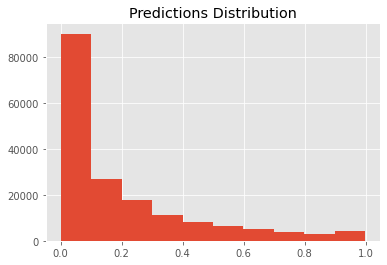

In [24]:
# Predictions histogram
predictions = bst.predict(test_x)
plt.title("Predictions Distribution")
plt.hist(predictions)
plt.show()

In [25]:
predictions

array([0.26973744, 0.18031212, 0.0493499 , ..., 0.6320687 , 0.19751008,
       0.03536405])

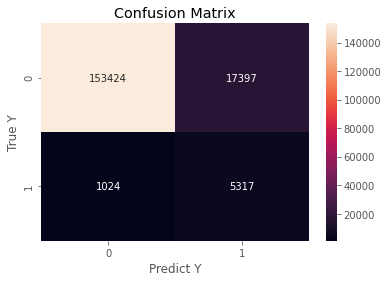

True Postive: 5317, True Negative 153424, False Postive: 17397, False Negative 1024


In [26]:
# Confusion matrix
predictions_with_cutpoint = list(map(lambda x: 1 if x > 0.5 else 0, predictions))
confusion_matrix_info = confusion_matrix(y_true=test_y, y_pred=predictions_with_cutpoint)
tn, fp, fn, tp = confusion_matrix(y_true=test_y, y_pred=predictions_with_cutpoint).ravel()
sns.heatmap(confusion_matrix_info, annot=True, fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predict Y")
plt.ylabel("True Y")
plt.show()

print("True Postive: {}, True Negative {}, False Postive: {}, False Negative {}".format(tp, tn, fp, fn))

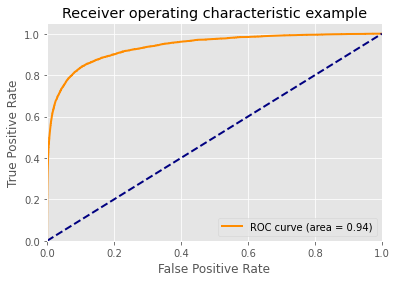

In [27]:
# Roc curve
fpr, tpr, _ = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Lightgbm model: f1=0.366 auc=0.635


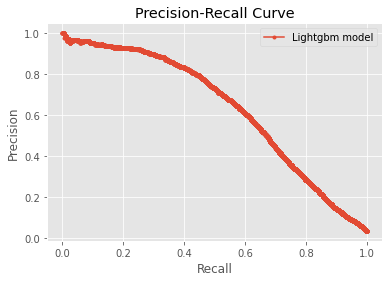

In [28]:
# Precision Recall Curve
precision, recall, _ = precision_recall_curve(test_y, predictions)
model_f1 = f1_score(test_y, predictions_with_cutpoint)
model_auc = auc(recall, precision)

# summarize scores
print('Lightgbm model: f1=%.3f auc=%.3f' % (model_f1, model_auc))

# plot the precision-recall curves
plt.plot(recall, precision, marker='.', label='Lightgbm model')
# axis labels
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

## Make kaggle predictions

In [29]:
kaggle_predictions = bst.predict(all_test_x)

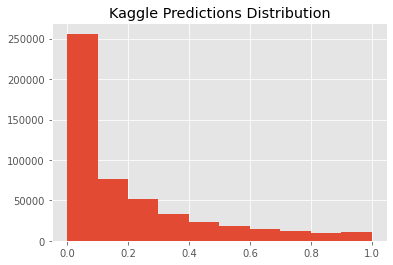

In [30]:
# Predictions histogram
plt.title("Kaggle Predictions Distribution")
plt.hist(kaggle_predictions)
plt.show()

In [31]:
# Write to csv
sample_submission= pd.read_csv("../data/sample_submission.csv")
sample_submission["isFraud"] = kaggle_predictions
sample_submission.to_csv("/tmp/submission.csv", index = False)

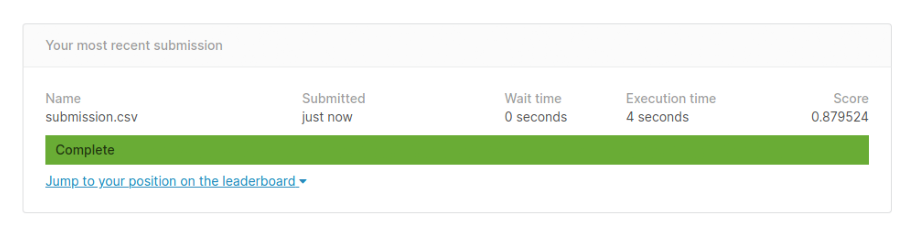

In [32]:
# Submission result
submission_result = mpimg.imread("../pictures/submission_result.png") 
plt.figure(figsize=(16, 9))
plt.imshow(submission_result)
plt.axis('off') 
plt.show()

## Reference
- [EDA and models](https://www.kaggle.com/artgor/eda-and-models#General-information)
- [kaggle discussion](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203)
- [Confusion Matrix](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)
- [Precision Recall Curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)